In [3]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance


# ==========================================================
# PATHS (single source of truth)
# ==========================================================
DATA_PATH = "D:/EY_Internship/p2p07_synthetic_10k_imbalance_with_pending.csv"

FEATURE_COLUMNS_PATH = "D:/EY_Internship/feature_columns.joblib"
INVOICE_BINS_PATH = "D:/EY_Internship/invoice_amt_bins.joblib"

LR_MODEL_PATH = "logreg_model.joblib"
LR_FEATURE_IMPORTANCE_PATH = "logreg_feature_importances.csv"
LR_PERM_IMPORTANCE_PATH = "logreg_permutation_importances.csv"



In [4]:

# ==========================================================
# preprocess_p2p (unchanged)
# ==========================================================
def preprocess_p2p(
    df: pd.DataFrame,
    *,
    feature_columns: list[str] | None = None,
    invoice_amt_bins: np.ndarray | None = None,
    is_training: bool = False
):
    df = df.copy()

    df["Invoice_Amount"] = pd.to_numeric(df.get("Invoice_Amount"), errors="coerce")
    df = df.dropna(subset=["Invoice_Amount"])

    if is_training:
        _, bins = pd.qcut(df["Invoice_Amount"], q=5, retbins=True, duplicates="drop")
        invoice_amt_bins = bins

    if invoice_amt_bins is not None:
        labels = ["Very_Low", "Low", "Medium", "High", "Very_High"]
        effective_k = len(invoice_amt_bins) - 1
        effective_labels = labels[:effective_k]

        df["Invoice_Amt_Bucket"] = pd.cut(
            df["Invoice_Amount"],
            bins=invoice_amt_bins,
            labels=effective_labels,
            include_lowest=True
        )
        df["Invoice_Amt_Bucket_Code"] = df["Invoice_Amt_Bucket"].cat.codes.replace(-1, np.nan)
    else:
        df["Invoice_Amt_Bucket"] = pd.qcut(
            df["Invoice_Amount"], q=5,
            labels=["Very_Low", "Low", "Medium", "High", "Very_High"],
            duplicates="drop"
        )
        df["Invoice_Amt_Bucket_Code"] = pd.qcut(
            df["Invoice_Amount"], q=5, labels=False, duplicates="drop"
        )

    df = pd.get_dummies(df, columns=["Invoice_Amt_Bucket"], drop_first=True)

    df["Invoice_Date"] = pd.to_datetime(df.get("Invoice_Date"), errors="coerce", dayfirst=True)
    df["Posting_Date"] = pd.to_datetime(df.get("Posting_Date"), errors="coerce", dayfirst=True)

    dup_lookup = df[["Doc_id", "Invoice_Amount", "Invoice_Date"]].rename(
        columns={
            "Doc_id": "Duplicate_doc_id",
            "Invoice_Amount": "Dup_Invoice_Amount",
            "Invoice_Date": "Dup_Invoice_Date",
        }
    )
    df = df.merge(dup_lookup, on="Duplicate_doc_id", how="left")

    df["Invoice_Amt_Diff"] = (df["Invoice_Amount"] - df["Dup_Invoice_Amount"]).abs()
    df["Invoice_Date_Diff_Days"] = (df["Invoice_Date"] - df["Dup_Invoice_Date"]).dt.days.abs()
    df["Invoice_Amt_Diff_Ratio"] = df["Invoice_Amt_Diff"] / (df["Invoice_Amount"] + 1)

    def date_diff_bucket(x):
        if pd.isna(x):
            return np.nan
        if x == 0:
            return "Same_Day"
        elif x <= 2:
            return "1_2_Days"
        else:
            return "Above_2_Days"

    df["Invoice_Date_Diff_Bucket"] = df["Invoice_Date_Diff_Days"].apply(date_diff_bucket)

    DROP_COLS = [
        "Doc_id", "Invoice_ID", "Vendor_Code", "Vendor_Name",
        "Vendor_GSTIN", "Invoice_Number", "Currency", "comments",
        "Duplicate_doc_id", "Exception_Type",
        "Invoice_Amt_Bucket", "Invoice_Amount", "Dup_Invoice_Amount",
    ]
    df_model = df.drop(columns=DROP_COLS, errors="ignore")

    categorical_cols = [
        "Invoice_Type",
        "Invoice_Source",
        "Business_Unit",
        "Exception_Number",
        "Invoice_Date_Diff_Bucket",
    ]
    df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

    if is_training:
        feature_columns = df_model.columns.tolist()
    else:
        if feature_columns is None:
            raise ValueError("feature_columns is required for inference.")
        for c in feature_columns:
            if c not in df_model.columns:
                df_model[c] = 0
        extra = [c for c in df_model.columns if c not in feature_columns]
        if extra:
            df_model = df_model.drop(columns=extra)
        df_model = df_model[feature_columns]

    return df_model, feature_columns, invoice_amt_bins



In [5]:

# ==========================================================
# Helpers: Top-K metrics for triage usefulness
# ==========================================================
def topk_metrics(y_true: np.ndarray, y_proba: np.ndarray, top_frac: float = 0.10):
    y_true = np.asarray(y_true).astype(int)
    y_proba = np.asarray(y_proba)

    n = len(y_true)
    k = max(1, int(np.ceil(top_frac * n)))

    idx = np.argsort(-y_proba)[:k]
    y_top = y_true[idx]

    tp_top = y_top.sum()
    total_pos = y_true.sum()

    precision_at_k = tp_top / k
    recall_at_k = tp_top / total_pos if total_pos > 0 else 0.0
    return precision_at_k, recall_at_k, k



In [6]:

# ==========================================================
# Load raw data + schema
# ==========================================================
df = pd.read_csv(DATA_PATH)
feature_columns = joblib.load(FEATURE_COLUMNS_PATH)

# ==========================================================
# Learn invoice bins from TRUE/FALSE only
# ==========================================================
df_tf = df[df["user_action_status"].isin(["TRUE", "FALSE"])].copy()
_, _, invoice_amt_bins = preprocess_p2p(df_tf, is_training=True)
joblib.dump(invoice_amt_bins, INVOICE_BINS_PATH)

# ==========================================================
# Preprocess full dataset aligned to schema
# ==========================================================
df_model, _, _ = preprocess_p2p(
    df,
    feature_columns=feature_columns,
    invoice_amt_bins=invoice_amt_bins,
    is_training=False
)


In [7]:

# ==========================================================
# Build training set
# ==========================================================
mask_tf = df["user_action_status"].isin(["TRUE", "FALSE"])
df_train = df_model.loc[mask_tf].copy()

df_train["y"] = df.loc[df_train.index, "user_action_status"].map({
    "FALSE": 0,
    "TRUE": 1
})

X = df_train[feature_columns]
y = df_train["y"].astype(int)

# ==========================================================
# Train / test split
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:

# ==========================================================
# Logistic Regression (with scaling + class_weight)
# ==========================================================
lr = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        solver="liblinear",       # stable for small/medium + L1/L2
        penalty="l2",
        C=1.0,
        class_weight="balanced",  # key for imbalance
        max_iter=2000,
        random_state=42
    ))
])

lr.fit(X_train, y_train)




Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42, solver='liblinear'))])

In [9]:

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
p_at_10, r_at_10, k = topk_metrics(y_test.values, y_proba, top_frac=0.10)

print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)
print(f"Precision@Top10% (K={k}):", p_at_10)
print(f"Recall@Top10% (K={k}):", r_at_10)




=== Logistic Regression ===
Confusion Matrix:
 [[792 648]
 [ 76  84]]
              precision    recall  f1-score   support

           0     0.9124    0.5500    0.6863      1440
           1     0.1148    0.5250    0.1883       160

    accuracy                         0.5475      1600
   macro avg     0.5136    0.5375    0.4373      1600
weighted avg     0.8327    0.5475    0.6365      1600

ROC-AUC: 0.5708116319444445
PR-AUC: 0.1378948406261593
Precision@Top10% (K=160): 0.1625
Recall@Top10% (K=160): 0.1625


In [10]:
joblib.dump(lr, LR_MODEL_PATH)
print("\nSaved model:", LR_MODEL_PATH)



Saved model: logreg_model.joblib


Saved coefficient importances: logreg_feature_importances.csv


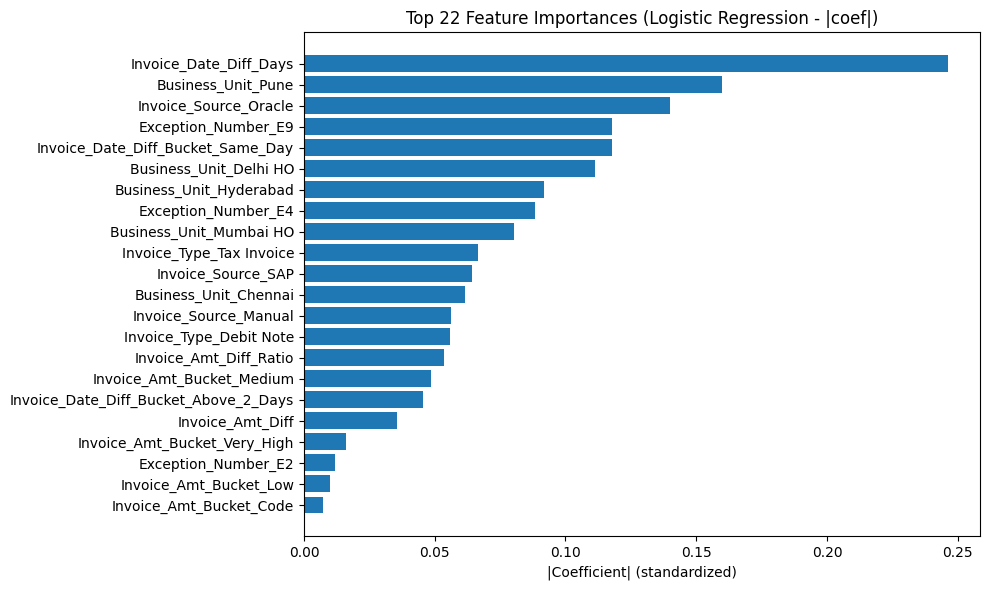

In [11]:

# ==========================================================
# Feature importance (coefficients)
# Note: coefficients are on standardized features (via StandardScaler)
# Use abs(coef) for magnitude; sign indicates direction.
# ==========================================================
coef = lr.named_steps["clf"].coef_.ravel()
imp_coef = pd.DataFrame({
    "feature": feature_columns,
    "coef": coef,
    "abs_coef": np.abs(coef)
}).sort_values("abs_coef", ascending=False)

imp_coef.to_csv(LR_FEATURE_IMPORTANCE_PATH, index=False)
print("Saved coefficient importances:", LR_FEATURE_IMPORTANCE_PATH)

topk_plot = 22
imp_plot = imp_coef.head(topk_plot)

plt.figure(figsize=(10, 6))
plt.barh(imp_plot["feature"][::-1], imp_plot["abs_coef"][::-1])
plt.xlabel("|Coefficient| (standardized)")
plt.title(f"Top {topk_plot} Feature Importances (Logistic Regression - |coef|)")
plt.tight_layout()
plt.show()


Saved permutation importances: logreg_permutation_importances.csv


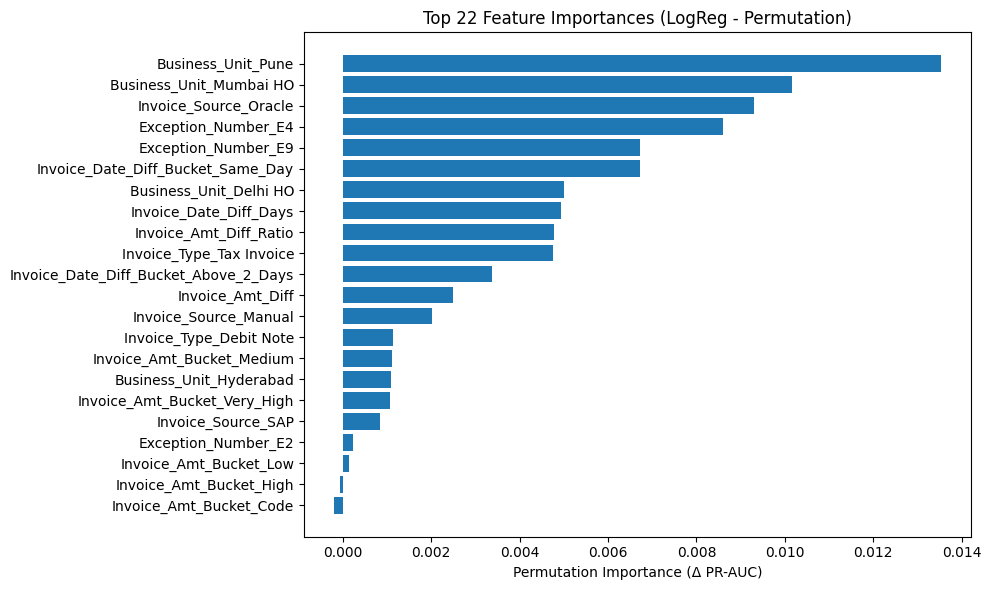

In [12]:

# ==========================================================
# Optional: Permutation Importance (more robust, slower)
# Uses PR-AUC as scoring because of imbalance.
# ==========================================================
perm = permutation_importance(
    lr,
    X_test, y_test,
    scoring="average_precision",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

imp_perm = pd.DataFrame({
    "feature": feature_columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

imp_perm.to_csv(LR_PERM_IMPORTANCE_PATH, index=False)
print("Saved permutation importances:", LR_PERM_IMPORTANCE_PATH)

imp_perm_plot = imp_perm.head(topk_plot)

plt.figure(figsize=(10, 6))
plt.barh(imp_perm_plot["feature"][::-1], imp_perm_plot["importance_mean"][::-1])
plt.xlabel("Permutation Importance (Δ PR-AUC)")
plt.title(f"Top {topk_plot} Feature Importances (LogReg - Permutation)")
plt.tight_layout()
plt.show()
